Reference:
* [W. Ahmad, "Making AI Art with Style Transfer using Keras".](https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216)
* [TensorFlow, "Neural Style Transfer: Creating Art with Deep Learning using tf.keras and eager execution".](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)

#### General Idea of Neural Transfer:
* 2 loss functions
  1. Lcontent: Difference between the content of the input image and the output one
  2. LsytleL: Difference between the style of style image and output one
* Minimize both loss functions with backpropagation

## Setup

#### Import modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

#### Configure tensorflow

In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [3]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


------------------------------------------------------------------------------------------------------------
## Prepare the image data

#### Fetch and visualize the source images

In [4]:
stylePics = ['wave', 'monet1', 'monet2', 'vangogh', 'mondrian']
beforePics = ['turtle', 'sunset', 'rocks', 'trees', 'street']
beforeDir, afterDir, styleDir = './Assets/Before/', './Assets/After/', './Assets/Style/'

beforeIdx, styleIdx = 0, 0 # Can be i, j in a loop

content_path = beforeDir + beforePics[beforeIdx] + '.jpg'
style_path = styleDir + stylePics[styleIdx] + '.jpg'

In [5]:
def load_img(img_path):
    # Resize image to be contained in a 512*512 box
    max_dim = 512
    img = Image.open(img_path)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    
    # Process into an [length * height * rgb] array and broadcast to a batch dimension 
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0) 
    return img

def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    if title: 
        plt.title(title)
    plt.imshow(out)

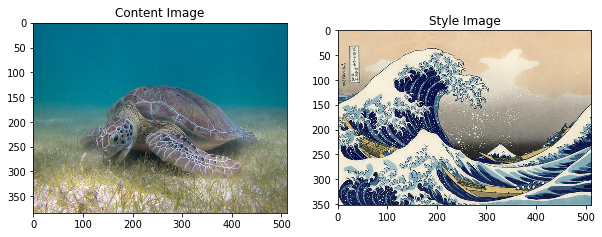

In [6]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

#### Preprocess and deprocess the image

In [7]:
def load_and_process_img(img_path):
    return tf.keras.applications.vgg19.preprocess_input(load_img(img_path))

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:  x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    # clip to maintain our values from within the 0-255 range.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#### Pull out specific intermdeiate layers which extracts the fratures (ie. content/style) desired

In [8]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def get_feature_representations(model, content_path, style_path):
    """Helper function to compute our content and style feature representations.

    This function will simply load and preprocess both the content and style 
    images from their path. Then it will feed them through the network to obtain
    the outputs of the intermediate layers. 

    Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image

    Returns:
    returns the style features and the content features. 
    """
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

------------------------------------------------------------------------------------------------------------
## Build model ([VGG19](https://keras.io/applications/#vgg19)) and loss functions

####  Input am image and output the intermediate layers representing content and style

In [10]:
def get_model():
    """ 
    This function will load the VGG19 model and access the intermediate layers. 
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model. 

    Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
    """
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # Build model - the Function API only needs the definition of input and output
    return models.Model(vgg.input, model_outputs)

#### Define content loss function
— the euclidean distance between the two intermediate (feature) representations of content image and base input: $$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$
where $F^l_{ij}(x) \in C_{nn}(x)$ and $P^l_{ij}(p) \in C_{nn}(p)$ describe the respective intermediate feature representation of the network with base input $x$ and content picture $p$ at layer $l$. ($C_{nn}(X)$ is the network fed by any image $X$)

In [11]:
def get_content_loss(base_content, target):
      return tf.reduce_mean(tf.square(base_content - target))

#### Define style loss function
— the mean squared distance between the feature correlation map (ie. Gram Matrix) of the style image and the input image. As there are multiple feature layers representing the style while only one for the content, the total style loss is a weighted sum of each layer's loss:
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
where we weight the contribution of each layer's loss by some factor $w_l$, which, in this case, is equally $w_l =\frac{1}{|L|}$.

In [12]:
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

#### Compute loss and gradients

In [13]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.

    Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.

    Returns:
    returns the total loss, style loss, content loss, and total variational loss
    """
    style_weight, content_weight = loss_weights

    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [14]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
        
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

## Run the style transfer

#### Minimize the loss with the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer
— we don't update the weights associated with our network, but instead we train our input image to minimize loss.

In [15]:
import IPython.display

def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
        
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False

    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }

    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 

        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()

            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss 

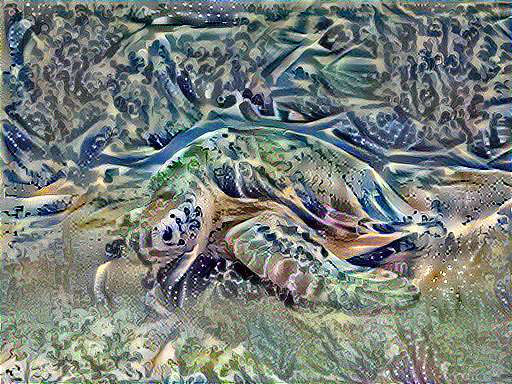

Iteration: 300
Total loss: 4.0551e+06, style loss: 2.8653e+06, content loss: 1.1898e+06, time: 0.0575s


In [ ]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

#### Visualize outputs

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))
        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

In [ ]:
show_results(best, content_path, style_path)